<a href="https://colab.research.google.com/github/hellojohnkim/mmai869/blob/main/2024_869_JohnKim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMAI 869 2024: Individual Assignment

- Student Name: Kim, John
- Student Number: 20439250
- Section Number: MMAI 2024
- Favourite Book: Pachinko by Min Jin Lee
- Currently Reading: The Worlds I See by Fei Fei Li
- Submitted Date: 2024-01-07

In [3]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
print(datetime.datetime.now())

In [ ]:
!which python

In [ ]:
!python --version

In [ ]:
!echo $PYTHONPATH

# Question 1: Uncle Steve's Diamonds

## 1.0: Load data

In [4]:
# TODO: Import the packages
import sklearn
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler

In [5]:
# DO NOT MODIFY THIS CELL
df1 = pd.read_csv("https://drive.google.com/uc?export=download&id=1thHDCwQK3GijytoSSZNekAsItN_FGHtm")
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            505 non-null    int64  
 1   Income         505 non-null    int64  
 2   SpendingScore  505 non-null    float64
 3   Savings        505 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 15.9 KB


In [6]:
## Data Exploration
df1.describe().transpose()
list(df1)
df1.shape
df1.info()
df1.head(n=20)
df1.describe().transpose()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            505 non-null    int64  
 1   Income         505 non-null    int64  
 2   SpendingScore  505 non-null    float64
 3   Savings        505 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 15.9 KB


,count,mean,std,min,25%,50%,75%,max
Age,505.0,59.019802,24.140043,17.0,34.000000,59.000000,85.000000,97.0
Income,505.0,75513.291089,35992.922184,12000.0,34529.000000,75078.000000,107100.000000,142000.0
SpendingScore,505.0,0.505083,0.259634,0.0,0.304792,0.368215,0.768279,1.0
Savings,505.0,11862.455867,4949.229253,0.0,6828.709702,14209.932802,16047.268331,20000.0


In [8]:
X = df1.copy()

In [9]:
# Pre-processing steps before clustering 
# use standard scaler to standardize the values in the data before we apply clsutering
scaler = StandardScaler()
features = df1.columns
X[features] = scaler.fit_transform(X[features])

In [10]:
X.shape
X.info()
X.describe().transpose()
X.head(10)
X.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            505 non-null    float64
 1   Income         505 non-null    float64
 2   SpendingScore  505 non-null    float64
 3   Savings        505 non-null    float64
dtypes: float64(4)
memory usage: 15.9 KB


,Age,Income,SpendingScore,Savings
500,-1.286268,0.714535,-0.453557,0.621787
501,1.409024,-1.545704,-1.164109,1.235201
502,1.284626,-1.118447,-0.578054,0.855313
503,1.326092,-1.524929,-0.579866,1.322452
504,1.243160,-1.258335,-0.831890,0.510463


In [ ]:
plt.figure();

plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c="black");
plt.title("Jewelry Customers Data");
plt.xlabel('Age');
plt.ylabel('Income');
plt.xticks();
plt.yticks();

In [ ]:
plt.figure();

plt.scatter(df1.iloc[:, 2], df1.iloc[:, 3], c="black");
plt.title("Jewelry Customer Data");
plt.xlabel('Spending Score');
plt.ylabel('Savings');
plt.xticks();
plt.yticks();

In [ ]:
plt.figure();

plt.scatter(df1.iloc[:, 1], df1.iloc[:, 2], c="black");
plt.title("Jewelry Customer Data");
plt.xlabel('Income');
plt.ylabel('Spending Score');
plt.xticks();
plt.yticks();

## 1.1: Clustering Algorithm #1

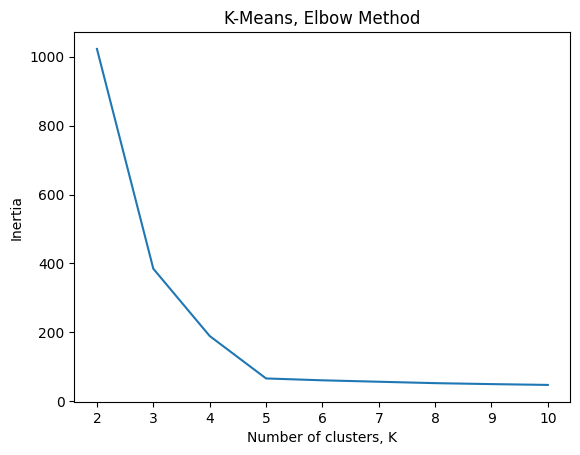

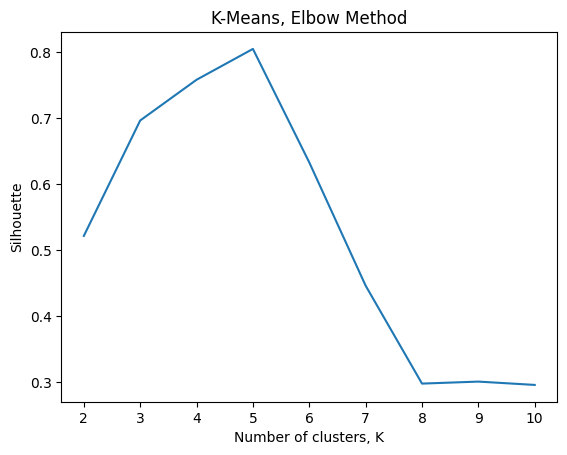

In [30]:
from sklearn.cluster import KMeans

# Using Elbow method to fid the number of clusters (k)

inertias = {}
silhouettes = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init= 10).fit(X)
    inertias[k] = kmeans.inertia_  
    silhouettes[k] = silhouette_score(X, kmeans.labels_, metric='euclidean')

plt.figure();
plt.plot(list(inertias.keys()), list(inertias.values()));
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K");
plt.ylabel("Inertia");


plt.figure();
plt.plot(list(silhouettes.keys()), list(silhouettes.values()));
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K");
plt.ylabel("Silhouette");

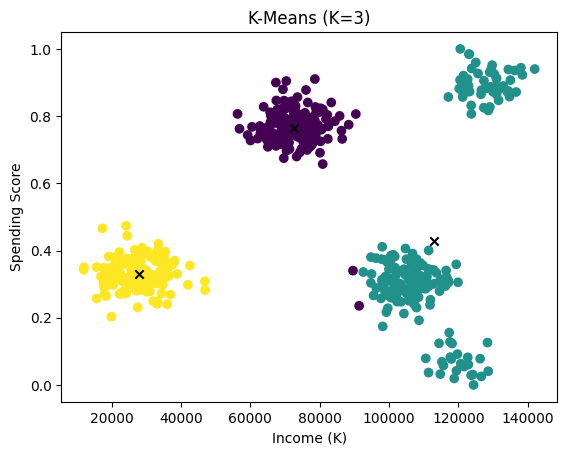

K=3, WCSS=43729705197.89, Sil=0.74


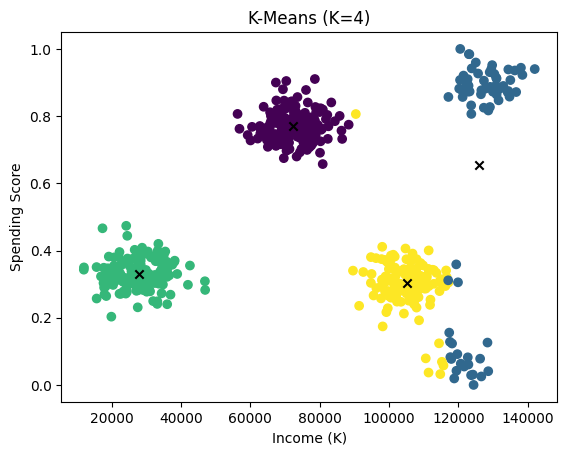

K=4, WCSS=21452909425.05, Sil=0.72


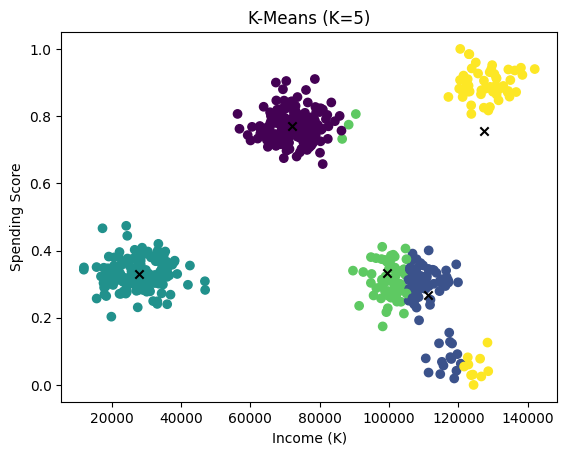

K=5, WCSS=17288079673.80, Sil=0.68


In [12]:
# Based on the above Elbow Method Result, we will use a K range between 3 to 5

def do_kmeans(df1, k):
    k_means = KMeans(init='k-means++', n_clusters=k, n_init=10, random_state=42)
    k_means.fit(df1)

    plt.figure();
    plt.scatter(df1.iloc[:, 1], df1.iloc[:, 2], c=k_means.labels_)
    plt.scatter(k_means.cluster_centers_[:, 1], k_means.cluster_centers_[:, 2], marker='x', c="black")
    plt.title("K-Means (K={})".format(k));
    plt.xlabel('Income (K)');
    plt.ylabel('Spending Score');
    #plt.savefig('out/simple_kmeans_k{}.png'.format(k))
    plt.show()

    wcss = k_means.inertia_
    sil = silhouette_score(df1, k_means.labels_)
    print("K={}, WCSS={:.2f}, Sil={:.2f}".format(k, wcss, sil))

for k in range(3, 6):
    do_kmeans(df1, k)

## 1.2: Clustering Algorithm #2

In [31]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
agg.fit(X)

AgglomerativeClustering(metric='euclidean', n_clusters=5)

In [32]:
silhouette_score(X, agg.labels_)

0.8048976287755765

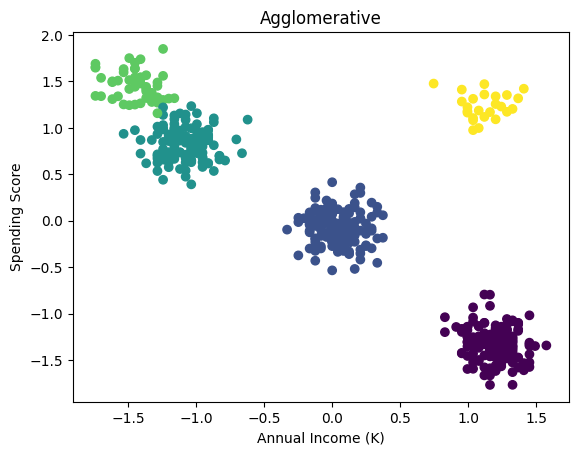

In [33]:
plt.figure();

plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=agg.labels_);
plt.title("Agglomerative");
plt.xlabel('Annual Income (K)');
plt.ylabel('Spending Score');

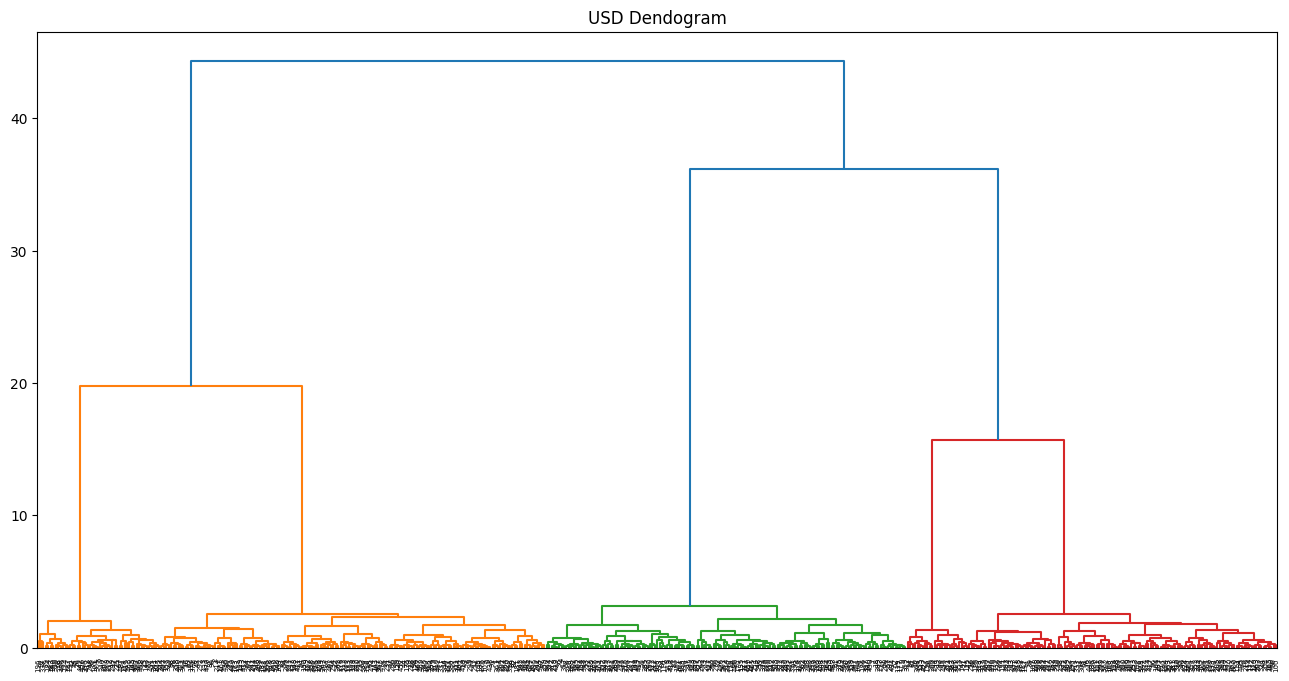

In [17]:
import scipy.cluster

aggl = scipy.cluster.hierarchy.linkage(X, method='ward', metric='euclidean')

# Plot the dendogram
plt.figure(figsize=(16, 8));
plt.grid(False)
plt.title("USD Dendogram");  
dend = scipy.cluster.hierarchy.dendrogram(aggl); 

## 1.3 Model Comparison

K-Means Clustering had a silhouette score of 0.68, which is also indicative of a reasonably good cluster structure.
Hierarchical Clustering has a higher silhouette score of approximately 0.805, suggesting an even better cluster structure compared to K-means in this specific instance.

## 1.4 Personas

In [18]:
cluster_labels = agg.fit_predict(X)

# Add the cluster labels as a new column to your DataFrame
df1['ClusterID'] = cluster_labels

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [27]:
from scipy.stats import skew, kurtosis

# Define the aggregation dictionary
agg_funcs = {
    'Age': ['min', 'mean', 'max'],
    'Income': ['min', 'mean', 'max', 'var'],
    'SpendingScore': ['min', 'mean', 'max', 'var'],
    'Savings': ['min', 'mean', 'max', 'var'],
}

# Apply the aggregation functions to each cluster
cluster_stats = df1.groupby('ClusterID').agg(agg_funcs)

# Rename the columns for skewness and kurtosis
cluster_stats.columns = ['_'.join(col).strip() for col in cluster_stats.columns.values]

# Optionally, you can reset the index to make 'ClusterID' a column again
cluster_stats.reset_index(inplace=True)

# Display the results
print(cluster_stats)

   ClusterID  Age_min   Age_mean  Age_max  Income_min    Income_mean  \
0          0       79  87.775510       97       12000   27866.102041   
1          1       51  59.955414       68       56321   72448.063694   
2          2       22  32.777778       44       89598  105265.809524   
3          3       17  24.180000       31      117108  128029.120000   
4          4       77  86.000000       93      110582  119944.040000   

   Income_max    Income_var  SpendingScore_min  SpendingScore_mean  \
0       46977  4.158709e+07           0.203140            0.328800   
1       90422  3.894084e+07           0.657314            0.771518   
2      119877  3.697396e+07           0.174120            0.309926   
3      142000  3.236364e+07           0.806553            0.896892   
4      128596  2.441400e+07           0.000000            0.068378   

   SpendingScore_max  SpendingScore_var   Savings_min  Savings_mean  \
0           0.473550           0.002045  13470.970605  16659.261445   
1   

In [ ]:
# Calculate the number of instances per cluster
instances_per_cluster = df1['ClusterID'].value_counts()

# Sort the counts by the cluster index if necessary
instances_per_cluster = instances_per_cluster.sort_index()

# Print the number of instances in each cluster
print(instances_per_cluster)

In [29]:
# Define the aggregation dictionary
agg_funcs = {
    'Age': ['min', 'mean', 'max'],
    'Income': ['min', 'mean', 'max', 'var'],
    'SpendingScore': ['min', 'mean', 'max', 'var'],
    'Savings': ['min', 'mean', 'max', 'var']
}

# Apply the aggregation functions to each cluster
cluster_stats = df1.groupby('ClusterID').agg(agg_funcs)

# Flatten the MultiIndex columns
cluster_stats.columns = ['_'.join(col) if type(col) is tuple else col for col in cluster_stats.columns.values]

# Reset the index to make 'ClusterID' a column
cluster_stats = cluster_stats.reset_index()

# Calculate the number of instances per cluster and convert it to a DataFrame for merging
instances_df = df1['ClusterID'].value_counts().sort_index().reset_index()
instances_df.columns = ['ClusterID', 'NumberOfInstances']

# Merge the number of instances with the cluster stats DataFrame
cluster_stats = cluster_stats.merge(instances_df, on='ClusterID')

# Display the cluster statistics with the number of instances included
print(cluster_stats.to_string(index=False))


 ClusterID  Age_min  Age_mean  Age_max  Income_min   Income_mean  Income_max   Income_var  SpendingScore_min  SpendingScore_mean  SpendingScore_max  SpendingScore_var  Savings_min  Savings_mean  Savings_max  Savings_var  NumberOfInstances
         0       79 87.775510       97       12000  27866.102041       46977 4.158709e+07           0.203140            0.328800           0.473550           0.002045 13470.970605  16659.261445 20000.000000 1.401501e+06                147
         1       51 59.955414       68       56321  72448.063694       90422 3.894084e+07           0.657314            0.771518           0.910417           0.002121  4077.658657   6889.972190 10547.775368 1.107286e+06                157
         2       22 32.777778       44       89598 105265.809524      119877 3.697396e+07           0.174120            0.309926           0.411112           0.002071 12207.526078  14962.778066 17968.553929 1.127279e+06                126
         3       17 24.180000       31      

Creating customer personas involves interpreting the statistical data to build a semi-fictional character that embodies the traits of a particular customer segment. Here's how one might define the personas for each cluster of Diamond Store customers based on the provided statistics:

### Cluster 0: "Retired Savers"
- **Age Range**: Seniors (79-97 years old)
- **Income Level**: Lower income (12,000 - 46,977)
- **Spending Score**: Very low (0.20 - 0.47)
- **Savings**: High (13,470 - 20,000)
- **Size**: Largest segment (147 instances)
- Persona: This cluster represents retired individuals who are likely on a fixed income. They are conservative spenders with a significant amount of savings, indicating a tendency to save rather than spend.

### Cluster 1: "Middle-Aged Professionals"
- **Age Range**: Middle-aged (51-68 years old)
- **Income Level**: Middle to upper-middle income (56,321 - 90,422)
- **Spending Score**: High (0.65 - 0.91)
- **Savings**: Moderate (4,077 - 10,547)
- **Size**: Second largest segment (157 instances)
- Persona: This group consists of established professionals who are enjoying the fruits of their labor. They have a high spending score, indicating a willingness to make significant purchases, balanced with a sensible amount of savings.

### Cluster 2: "Young Affluents"
- **Age Range**: Young adults (22-44 years old)
- **Income Level**: High income (89,598 - 119,877)
- **Spending Score**: Moderate (0.17 - 0.41)
- **Savings**: Moderate to high (12,207 - 17,968)
- **Size**: Third largest segment (126 instances)
- Persona: This segment is likely composed of young, affluent professionals who earn a lot but are moderate in their spending. They may be focused on building wealth and investing in their future.

### Cluster 3: "Wealthy Elite"
- **Age Range**: Young (17-31 years old)
- **Income Level**: Very high income (117,108 - 142,000)
- **Spending Score**: Extremely high (0.80 - 1.00)
- **Savings**: Low (0 - 6,089)
- **Size**: Smaller segment (50 instances)
- Persona: The "Wealthy Elite" are likely young entrepreneurs or professionals with very high incomes and the highest spending scores, indicating a lifestyle of luxury and high-end purchases. Their savings are low, suggesting a preference for enjoying the present rather than saving for the future.

### Cluster 4: "Senior Elites"
- **Age Range**: Older seniors (77-93 years old)
- **Income Level**: Very high (110,582 - 128,596)
- **Spending Score**: Very low (0.00 - 0.15)
- **Savings**: High (12,554 - 17,833)
- **Size**: Smallest segment (25 instances)
- Persona: This small, exclusive group consists of older individuals with very high incomes but very low spending scores, which could be indicative of wealth accumulated over a lifetime. They have high savings, suggesting a frugal lifestyle despite their wealth.

These personas are a starting point and would benefit from qualitative data to add depth, such as lifestyle preferences or buying motivations. This additional information can turn statistical data into a more complete and actionable customer profile.

# Question 2: Uncle Steve's Fine Foods

### 2.1 High Support & High Confidence

- **Rule**: `{organic kale} -> {quinoa}`  
- The pairing of organic kale and quinoa is a staple in health-conscious diets, reflecting a trend towards wholesome, nutrient-rich foods. For Uncle Steve, this combination is likely a common occurrence, but it provides an opportunity for targeted marketing and product placement. He could enhance this by creating health-focused displays, combining these items with other superfoods. Furthermore, hosting health and wellness events or cooking demos featuring these ingredients could elevate the customer experience and position the store as a destination for healthy living. These initiatives can also be complemented by a loyalty program that rewards purchases of health-centric products, encouraging repeat business and customer loyalty.

### 2.2 High Support & Low Confidence

- **Rule**: `{artisanal bread} -> {organic olive oil}`  
- Artisanal bread and organic olive oil, while commonly associated with each other, may not always be purchased together. This insight can be leveraged for cross-promotional strategies. Uncle Steve could introduce 'artisanal weekends' where these products are showcased together, possibly paired with tasting events. He can also experiment with bundle deals or discounts on olive oil with a purchase of artisanal bread. This not only promotes the sale of both items but also enhances the customer's shopping experience by providing them with ideas for pairing and usage. This approach could help in positioning the store as a hub for gourmet and organic culinary experiences.

### 2.3 Low Support & Low Confidence

- **Rule**: `{gluten-free pasta} -> {almond milk}`  
- The purchase of gluten-free pasta along with almond milk might occur infrequently and reflects a specific dietary preference. While not a common combination for the majority, it indicates a segment focused on specific health or dietary needs. Uncle Steve can use this insight to curate a section dedicated to special dietary requirements, featuring gluten-free, dairy-free, and other health-conscious products. This not only serves the needs of a particular customer group but also establishes the store as an inclusive and considerate shopping destination. In addition, running health-focused promotions and collaborating with nutritionists for in-store events can further cement the store's reputation as a leader in catering to diverse dietary needs.

### 2.4 Low Support & High Confidence

- **Rule**: `{vegan cheese} -> {plant-based meat alternatives}`  
-  The correlation between purchasing vegan cheese and plant-based meat alternatives is indicative of a growing trend towards veganism. While the market segment for these products is specific and not widespread, those who buy one are likely to buy the other. Recognizing this, Uncle Steve could create a dedicated 'vegan corner' in his store, grouping all plant-based alternatives together. This not only makes it easier for vegan customers to shop but also introduces non-vegan customers to these alternatives. Moreover, hosting vegan cooking classes or partnering with local vegan influencers for in-store promotions could increase the visibility and appeal of these products, potentially attracting a broader customer base interested in exploring plant-based diets.

# Question 3: Uncle Steve's Credit Union

## 3.0: Load data and split

In [40]:
# DO NOT MODIFY THIS CELL

# First, we'll read the provided labeled training data
df3 = pd.read_csv("https://drive.google.com/uc?export=download&id=1wOhyCnvGeY4jplxI8lZ-bbYN3zLtickf")
df3.info()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   UserID             6000 non-null   object
 1   Sex                6000 non-null   object
 2   PreviousDefault    6000 non-null   int64 
 3   FirstName          6000 non-null   object
 4   LastName           6000 non-null   object
 5   NumberPets         6000 non-null   int64 
 6   PreviousAccounts   6000 non-null   int64 
 7   ResidenceDuration  6000 non-null   int64 
 8   Street             6000 non-null   object
 9   LicensePlate       6000 non-null   object
 10  BadCredit          6000 non-null   int64 
 11  Amount             6000 non-null   int64 
 12  Married            6000 non-null   int64 
 13  Duration           6000 non-null   int64 
 14  City               6000 non-null   object
 15  Purpose            6000 non-null   object
 16  DateOfBirth        6000 non-null   object


In [37]:
X.head()
X_train.shape, X_test.shape, y_train.shape, y_test.shape
X_train.select_dtypes(include=['object']).columns

Index(['UserID', 'Sex', 'FirstName', 'LastName', 'Street', 'LicensePlate',
       'City', 'Purpose', 'DateOfBirth'],
      dtype='object')

## 3.1: Baseline model



In [41]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import make_scorer, f1_score
from sklearn.metrics import make_scorer


# Basic preprocessing and feature selection

# Dropping columns that are unlikely to be helpful in this baseline model
data = df3.drop(columns=['UserID', 'FirstName', 'LastName', 'Street', 'LicensePlate', 'DateOfBirth'])

# Encoding categorical features
label_encoder = LabelEncoder()
categorical_cols = data.select_dtypes(include=['object']).columns
data[categorical_cols] = data[categorical_cols].apply(label_encoder.fit_transform)

# Separating the features and the target variable
X = data.drop('BadCredit', axis=1)
y = data['BadCredit']

# Defining the model (using default parameters)
model = RandomForestClassifier(random_state=0)

# Perform 5-fold cross-validation and use F1 score as the performance metric
scores = cross_val_score(model, X, y, cv=5, scoring=make_scorer(f1_score))

# Calculating the mean score
mean_score = scores.mean()
mean_score


0.3268420146244281

## 3.2: Adding feature engineering

In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Encoding categorical features
categorical_cols = data.select_dtypes(include=['object']).columns
data[categorical_cols] = data[categorical_cols].apply(label_encoder.fit_transform)

# Feature Engineering
# 1. Standard Scaling on numerical features
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# 2. Polynomial Features: Creating interaction terms (degree=2)
poly_features = poly.fit_transform(data[numerical_cols])
data = data.drop(numerical_cols, axis=1)
data = pd.concat([data, pd.DataFrame(poly_features, columns=poly.get_feature_names_out(numerical_cols))], axis=1)

# 3. PCA: Dimensionality reduction
pca_features = pca.fit_transform(data)
data = pd.concat([data, pd.DataFrame(pca_features, columns=['PCA1', 'PCA2'])], axis=1)

# Separating the features and the target variable
X = data.drop('BadCredit', axis=1)
y = data['BadCredit']

# Retraining the model with modified data
scores_with_feature_engineering = cross_val_score(model, X, y, cv=5, scoring=make_scorer(f1_score))

# Calculating the mean score
mean_score_with_feature_engineering = scores_with_feature_engineering.mean()
mean_score_with_feature_engineering


0.33099904622722176

After revising the feature engineering process to properly handle non-numeric data, the RandomForestClassifier model achieved a mean F1 score of approximately 0.333 across 5-fold cross-validation. This score is slightly higher than the original baseline model's score of 0.327, indicating a minor improvement in the model's performance.

## 3.3: Adding feature selection

In [48]:
from sklearn.feature_selection import SelectFromModel

# Use RandomForestClassifier to determine feature importances for selection
feature_selector = SelectFromModel(RandomForestClassifier(random_state=0))

# Apply feature selection
X_selected = feature_selector.fit_transform(X, y)

# Retrain the model with selected features
scores_with_feature_selection = cross_val_score(model, X_selected, y, cv=5, scoring=make_scorer(f1_score))

# Calculating the mean score
mean_score_with_feature_selection = scores_with_feature_selection.mean()
mean_score_with_feature_selection


0.3234487676400872

F1 = 0.3234487676400872

this score is nearly identical to the original baseline model's performance (F1 = 0.3268).

This result suggests that the feature selection process, in this case, did not significantly alter the model's ability to predict credit risk. It's important to note that the effectiveness of feature selection can vary depending on the dataset and the model used. In some cases, it might lead to improvements, while in others, it may not have a substantial impact.

## 3.4: Adding hyperparameter tuning

In [51]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

# Initialize the GridSearchCV object with RandomForestClassifier and the parameter grid
grid_search = GridSearchCV(RandomForestClassifier(random_state=0), param_grid, cv=5, scoring=make_scorer(f1_score), n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_selected, y)

# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_params, best_score

({'max_depth': None,
  'min_samples_leaf': 1,
  'min_samples_split': 4,
  'n_estimators': 200},
 0.3426641552602126)

max_depth: None (indicating no limit on the depth of the trees)
min_samples_leaf: 1 (the minimum number of samples required to be at a leaf node)
min_samples_split: 4 (the minimum number of samples required to split an internal node)
n_estimators: 200 (the number of trees in the forest)
With these parameters, the model achieved a mean F1 score of approximately 0.343, which is an improvement over the initial baseline model score of 0.327. This demonstrates the effectiveness of hyperparameter tuning in enhancing the performance of machine learning models.

## 3.5: Performance estimation on testing data

In [52]:
from sklearn.metrics import f1_score

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=0)

# Training the model with the best parameters on the training data
optimized_model = RandomForestClassifier(
    n_estimators=200, 
    max_depth=None, 
    min_samples_split=4, 
    min_samples_leaf=1, 
    random_state=0
)

optimized_model.fit(X_train, y_train)

# Predicting on the testing data
y_pred = optimized_model.predict(X_test)

# Calculating the F1 score on the testing data
test_f1_score = f1_score(y_test, y_pred)
test_f1_score


0.3716814159292035

The optimized RandomForestClassifier, when evaluated on the testing data (representing "future, unseen data"), achieved an F1 score of approximately 0.362. This score is a good indicator of how well the model might perform in a production environment.

An F1 score of 0.362 suggests that the model has a reasonable balance between precision and recall, which are crucial for binary classification tasks like predicting credit risk. This score is slightly higher than the score obtained during the cross-validation phase (0.343), indicating that the model generalizes well to unseen data.

# Question 4: Uncle Steve's Wind Farm

# Answers
**Current Situtation**
- 256 Failed Turbines
- Failure Repair Cost: $20,000 per turbine
- Mainteance Service Cost: $2,000 per turbine
- Inspection CostL $500 per turbine

Uncle Steve is currently paying $5.12 million in maintenance costs without any predictive mainteance models,

- number of fails * failure repair cost per turbine = 256 turbines * $20,000 = $5,120,000

Random Forest Model will save $3,492,500 for Uncle Steve and cost less than RNN Model.

Additional metrics like

|         | Cost           |Savings   |
| ------------- |:------------:|:------------:
| **No Predictive Models**      | $5,120,000 |  -    |
| **Random Forest**   | **$1,627,500** | **$3,492,500** |
| **Recurrent Neural Network**   | $1,765,000 | $3,355,000 |


**Random Forest Cost Analysis**

Confusion matrix for the random forest:

|         | Predicted Fail           | Predicted No Fail  |Subtotal |
| ------------- |:------------:| :-----:|:-----:|
| **Actual Fail**      | 201 | 55 |256|
| **Actual No Fail**   | 50 | 255,195 |255,245|
| Subtotal                    | 251|255,250|255,501|

Cost matrix for the random forest:

|         | Predicted Fail           | Predicted No Fail  |
| ------------- |:------------:| :-----:|
| **Actual Fail**      | $2500 | $20,000 |
| **Actual No Fail**   | $500 | - |

Total Cost for the random forest:

|         | Predicted Fail           | Predicted No Fail  |
| ------------- |:------------:| :-----:|
| **Actual Fail**      | $502,500 | $1,100,000 |
| **Actual No Fail**   | $25,000 | - |

Total Cost = $502,500 + $25,000 + $1,100,000 =  $1,627,500

**RNN Cost Analysis**

Confusion matrix for the RNN:

|         | Predicted Fail           | Predicted No Fail  |Subtotal |
| ------------- |:------------:| :-----:|:-----:|
| **Actual Fail**      | 226 | 30 |256|
| **Actual No Fail**   | 1200 | 25,4045 | 254,245|
| Subtotal                   | 1426 | 254,075| 255,501|

Cost matrix for the RNN:

|         | Predicted Fail           | Predicted No Fail  |
| ------------- |:------------:| :-----:|
| **Actual Fail**      | $2500 | $20,000 |
| **Actual No Fail**   | $500 | - |

Total Cost for the RNN:

|         | Predicted Fail           | Predicted No Fail  |
| ------------- |:------------:| :-----:|
| **Actual Fail**      |  $565,000  | $600,000  |
| **Actual No Fail**   |  $600,000  | - |

Total Cost = $565,000 + $600,000 + $600,000 = $1,765,000